In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys, os, pathlib
import numpy as np
import pandas as pd
import skimage
import torch

sys.path.append('../..')
import project
from project.core.utils import pprint

torch.cuda.is_available()

True

In [4]:
!nvidia-smi

Tue Feb 10 01:52:50 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               On  |   00000000:25:00.0 Off |                  Off |
| 30%   29C    P8             28W /  300W |       5MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
config = project.core.fileio.load_config('2026-02-02_config.yaml')

Loading 2026-02-02_config.yaml


In [6]:
data_config = config['dataset'].copy()
data_config['examples']['subjects'] = '/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/2026-01-26_preprocessed.csv'
pprint(data_config)

dict(len=5)
├── 'name':      'ShapeNet'
├── 'root':      '/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem'
├── 'examples':  dict(len=2)
|   ├── 'subjects': '/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/2026-01-26_preprocessed.csv'
|   └── 'variant':  '2026-01-15'
├── 'metadata':  dict(len=3)
|   ├── 'parse_metadata': True
|   ├── 'unit_policy':    'prefer_metadata'
|   └── 'default_unit':   0.01
└── 'selectors': dict(len=2)
    ├── 'material_mask': 'uniform-seed'
    └── 'input_image':   'no-noise'


In [7]:
img_config = config['preprocessing']['image_generation'].copy()
pprint(img_config)

dict(len=4)
├── 'material_catalog': '/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/2026-02-10_materials.csv'
├── 'texture_source':   dict(len=2)
|   ├── 'annotations': '/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/2025-11-20_annotations.csv'
|   └── 'use_solid':   True
├── 'intensity_model':  dict(len=12)
|   ├── 'density_scale':      1000.0
|   ├── 'density_power':      1.0
|   ├── 'elastic_scale':      1000.0
|   ├── 'elastic_power':      -1.0
|   ├── 'bias_offset':        0.0
|   ├── 'bias_from_density':  1.0
|   ├── 'bias_from_elastic':  0.0
|   ├── 'bias_from_product':  0.0
|   ├── 'range_offset':       0.5
|   ├── 'range_from_density': 0.0
|   └── <2 more items>
└── 'noise_model':      dict(len=8)
    ├── 'tex_noise_len': 2.0
    ├── 'tex_noise_std': 0.0
    ├── 'mul_noise_len': 128
    ├── 'mul_noise_std': 0.0
    ├── 'add_noise_len': 0.5
    ├── 'add_noise_std': 0.0
    ├── 'psf_sigma':     0.0
    └── 'mat_sigma':     0.0


In [13]:
%autoreload
import project.preprocessing.materials as materials

mat_df = materials.load_material_catalog(img_config['material_catalog'])
mat_df

,material_name,density_val,elastic_val,material_freq,texture_class,texture_id
0,Background,NaN,NaN,NaN,<NA>,<NA>
1,VerySoft,1000.0,1000.0,0.2,marble,b25c0f2ee0edc563
2,Soft,1000.0,2000.0,0.2,stone,a6c66d0eeaca8c03
3,Medium,1000.0,3000.0,0.2,paper,80703cf49d2a14c5
4,Hard,1000.0,5000.0,0.2,leather,17fababfd85461d1
5,VeryHard,1000.0,9000.0,0.2,fabric,e99e6b2fa82e040a


In [14]:
%autoreload
import project.preprocessing.textures as textures

tex_df = textures.load_texture_annotations(img_config['texture_source']['annotations'])
tex_df

,texture_class,image_path,image_annotation,image_valid,solid_path,solid_annotation,solid_valid,inverted
tid,,,,,,,,
8a1b661a4dd6aa56,leather,/ocean/projects/asc170022p/mtragoza/lung-proje...,leather,True,/ocean/projects/asc170022p/mtragoza/SolidTextu...,leather,False,False
7961ca6ba8321e68,stone,/ocean/projects/asc170022p/mtragoza/lung-proje...,stone,True,/ocean/projects/asc170022p/mtragoza/SolidTextu...,"stone, some LFO",False,False
7f0c33324e26f5c9,wood,/ocean/projects/asc170022p/mtragoza/lung-proje...,wood,True,/ocean/projects/asc170022p/mtragoza/SolidTextu...,"wood, anisotropic",False,False
cc619f4203d2f2a7,fabric,/ocean/projects/asc170022p/mtragoza/lung-proje...,fabric,True,/ocean/projects/asc170022p/mtragoza/SolidTextu...,fine fabric,False,False
b0d1ade26ee8c663,paper,/ocean/projects/asc170022p/mtragoza/lung-proje...,paper,True,/ocean/projects/asc170022p/mtragoza/SolidTextu...,paper - holes,False,False
2001a5b9a15a670c,wood,/ocean/projects/asc170022p/mtragoza/lung-proje...,wood,True,/ocean/projects/asc170022p/mtragoza/SolidTextu...,"wood, very aniso",True,False
2c5c6a3551d80fb0,fabric,/ocean/projects/asc170022p/mtragoza/lung-proje...,fabric,True,/ocean/projects/asc170022p/mtragoza/SolidTextu...,"fabric, gridlike",False,False
a6c66d0eeaca8c03,stone,/ocean/projects/asc170022p/mtragoza/lung-proje...,stone,True,/ocean/projects/asc170022p/mtragoza/SolidTextu...,stone,True,False
b25c0f2ee0edc563,marble,/ocean/projects/asc170022p/mtragoza/lung-proje...,marble,True,/ocean/projects/asc170022p/mtragoza/SolidTextu...,"marble, good!",True,False


In [15]:
%autoreload
cache = textures.TextureCache(annotations=tex_df)
len(cache)

21

In [16]:
use_solid = True
proc_spec = textures.PreprocessSpec(do_crop=True, do_filter=True, normalize=True)
pprint(proc_spec)

PreprocessSpec()
├── do_crop:     True
├── crop_size:   256
├── do_filter:   True
├── cutoff_freq: 0.03125
├── grayscale:   False
├── normalize:   True
├── norm_mode:   'median_iqr'
└── per_channel: False


In [18]:
# load and preprocess textures
for idx, row in mat_df.iterrows():
    if pd.notnull(row.texture_id):
        tex = cache.get(row.texture_id, use_solid, proc_spec)

Loading /ocean/projects/asc170022p/mtragoza/SolidTextureNets/Trained/b25c0f2ee0edc563.nii
Cropping texture
Filtering texture
Normalizing texture
Loading /ocean/projects/asc170022p/mtragoza/SolidTextureNets/Trained/a6c66d0eeaca8c03.nii
Cropping texture
Filtering texture
Normalizing texture
Loading /ocean/projects/asc170022p/mtragoza/SolidTextureNets/Trained/80703cf49d2a14c5.nii
Cropping texture
Filtering texture
Normalizing texture
Loading /ocean/projects/asc170022p/mtragoza/SolidTextureNets/Trained/17fababfd85461d1.nii
Cropping texture
Filtering texture
Normalizing texture
Loading /ocean/projects/asc170022p/mtragoza/SolidTextureNets/Trained/e99e6b2fa82e040a.nii
Cropping texture
Filtering texture
Normalizing texture


In [8]:
# analyzing a specific texture
row

NameError: name 'row' is not defined

In [20]:
tex = cache.get(row.texture_id, use_solid, proc_spec)
textures.describe_texture(tex)

shape: (256, 256, 256, 3)
dtype: float64
range: [-2.4827, 2.1267]
mean (std):   -0.0030 (0.6601)
median (IQR): 0.0000 (1.0000)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.19891879309695837..1.365113134545977].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5719599260006689..1.4303132120663842].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5714815086599234..1.3593320377826692].


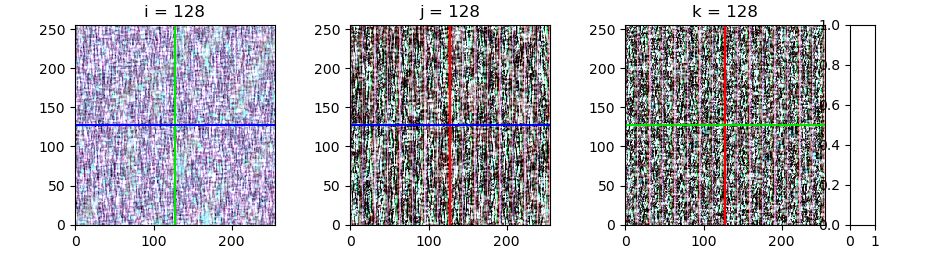

In [26]:
import project.visual.matplotlib as mpl_viz
mpl_viz.SliceViewer((tex + 1) / 2)

(<Figure size 950x300 with 1 Axes>,
 array([[<Axes: ylabel='Count'>]], dtype=object))

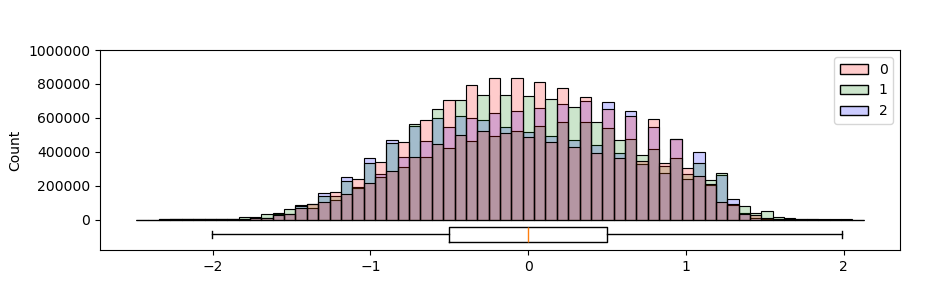

In [27]:
textures.plot_histogram(tex, bins=64)

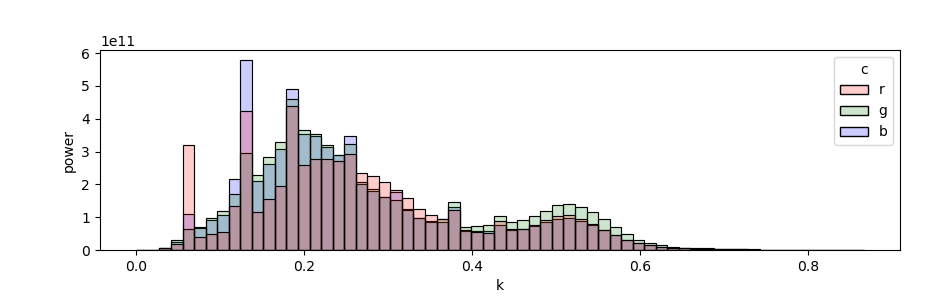

In [31]:
P, k = textures.power_spectrum(tex)
r = (k*k).sum(axis=-1)**0.5
textures.plot_psd(P, r, bins=np.linspace(0, r.max(), 64))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3348302796053886..1.1573126018875346].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.18782348161479412..1.262998760836592].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.19773554336827304..1.277874228170313].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.24303762271823615..1.1356115090080066].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.357534203674966..1.1271197344167447].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.21467937530716263..1.1875268763726772].
Clipping input data t

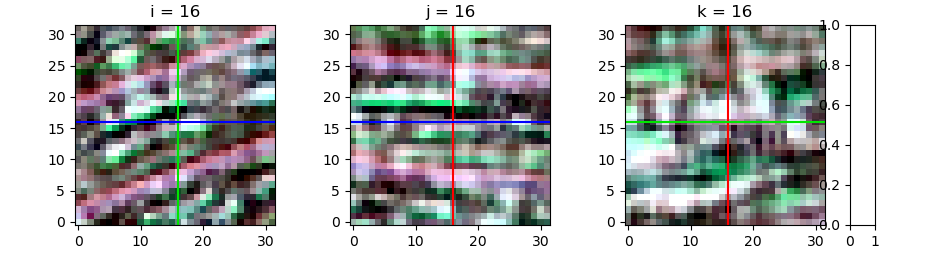

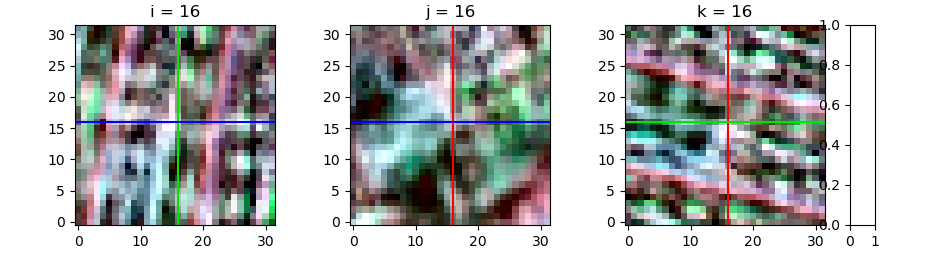

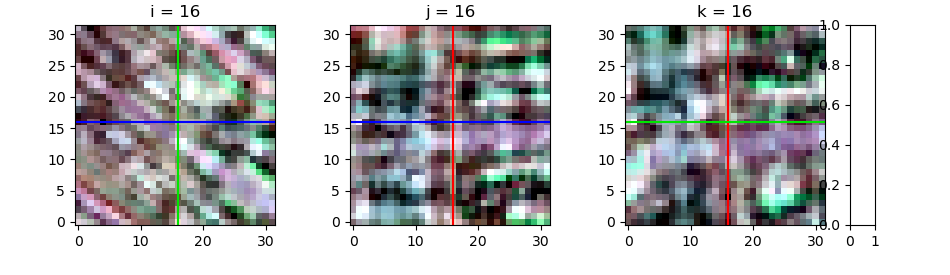

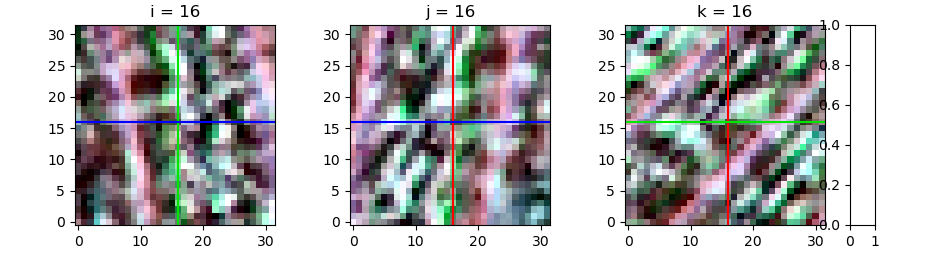

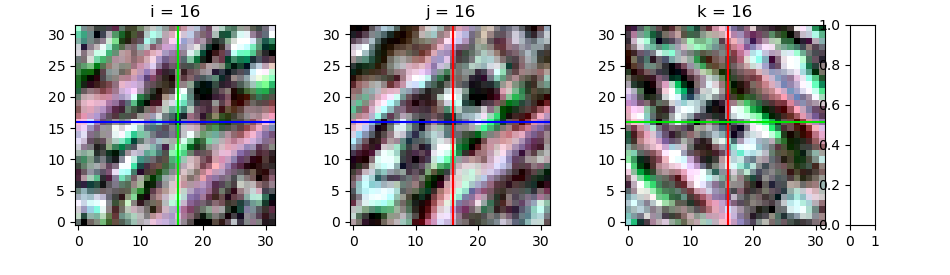

In [33]:
# sample random patches
patch_size = 32

shape = (patch_size, patch_size, patch_size)
points = textures.grid_coords(shape, axis=-1)
points = points.reshape(-1, 3)

n_samples = 5
for s in range(n_samples):
    pts = textures.random_transform(points, scale=patch_size, seed=s)
    patch = textures.interpolate_volume(tex, pts, order=1)
    patch = patch.reshape(shape + (3,))
    mpl_viz.SliceViewer((patch + 1)/2)


In [17]:
# image generation from textures + material labels
data_config = config['dataset'].copy()
data_config['examples']['subjects'] = '100_subjects.csv'
examples = project.api.get_examples(data_config)
len(examples)

Gathering examples


100

In [66]:
mat_df

,material_name,density_val,elastic_val,material_freq,texture_class,texture_id
0,Background,NaN,NaN,NaN,<NA>,<NA>
1,VerySoft,1000.0,1000.0,0.2,marble,b25c0f2ee0edc563
2,Soft,1000.0,2000.0,0.2,stone,a6c66d0eeaca8c03
3,Medium,1000.0,3000.0,0.2,paper,80703cf49d2a14c5
4,Hard,1000.0,5000.0,0.2,leather,17fababfd85461d1
5,VeryHard,1000.0,9000.0,0.2,fabric,e99e6b2fa82e040a


Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b78edd5bc31b19ae0681a1280473149/masks/mask_regions_uniform-seed.nii.gz


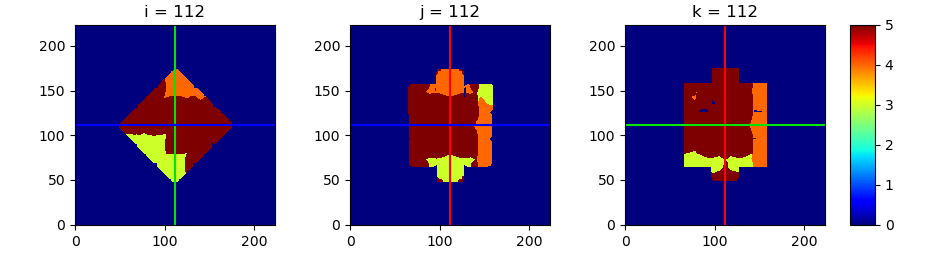

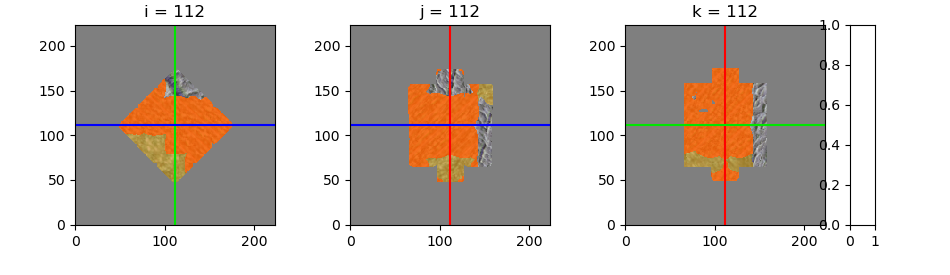

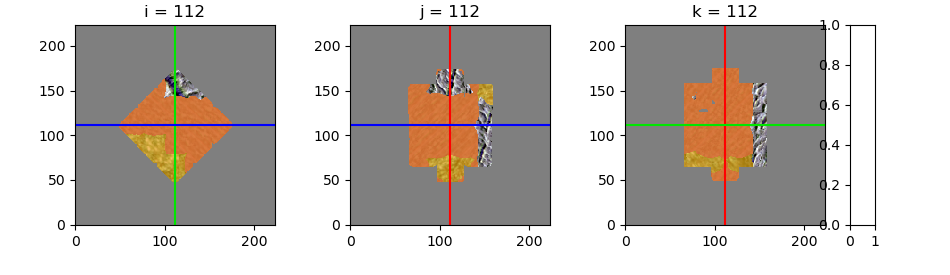

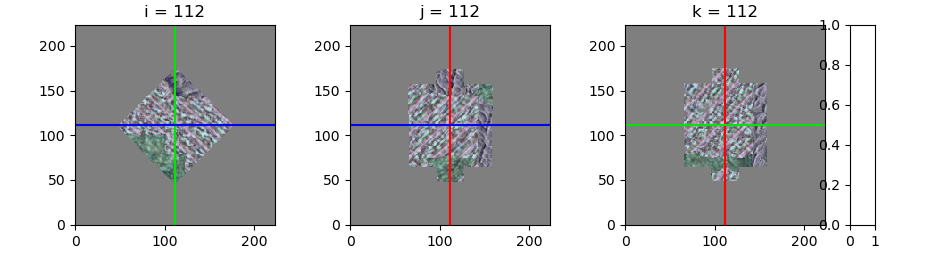

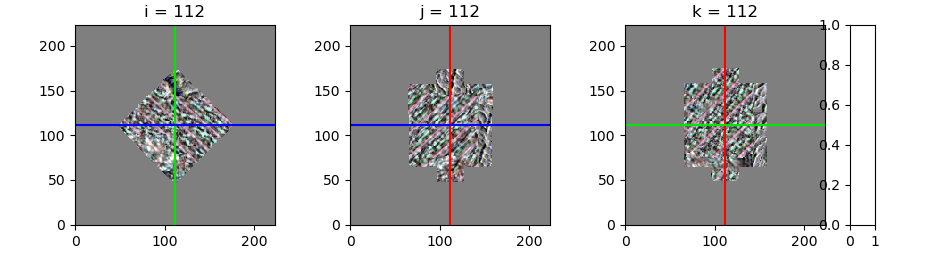

In [65]:
%autoreload
from project.preprocessing import textures, materials, image_generation
import project.visual.matplotlib as mpl_viz

ex = np.random.choice(examples)
mat_path = ex.paths['material_mask']
mat_mask = project.core.fileio.load_nibabel(mat_path).get_fdata()
mpl_viz.SliceViewer(mat_mask, cmap='jet')

def make_texture_map(proc_spec):
    def texture_map(label):
        tid = mat_df.loc[label].texture_id
        return cache.get(tid, use_solid, proc_spec)
    return texture_map

crop_size = 128
specs = [
    textures.PreprocessSpec(do_crop=True, crop_size=crop_size, do_filter=True, normalize=True, norm_mode='min_max'),
    textures.PreprocessSpec(do_crop=True, crop_size=crop_size, do_filter=True, normalize=True, norm_mode='mean_std'),
    textures.PreprocessSpec(do_crop=True, crop_size=crop_size, do_filter=True, normalize=True, norm_mode='min_max', per_channel=True),
    textures.PreprocessSpec(do_crop=True, crop_size=crop_size, do_filter=True, normalize=True, norm_mode='mean_std', per_channel=True),
]
for spec in specs:
    texture_map = make_texture_map(spec)
    image = image_generation.generate_simple_image(mat_mask, texture_map, seed=0, rgb=not spec.grayscale)
    if spec.normalize:
        if spec.norm_mode == 'mean_std':
            image = image / 2
        elif spec.norm_mode == 'median_iqr':
            image = image / 2
    clipped = np.clip(image, -1, 1)
    mpl_viz.SliceViewer((clipped + 1) / 2, cmap='gray', clim=(0,1))


In [298]:
import torch

class PatchDataset(torch.utils.data.Dataset):

    def __init__(self, textures, patch_size=32, n_patches=100):
        self.textures = textures
        self.patch_size = patch_size

        self.points = make_grid_points(patch_size).reshape(-1, 3)
        self.items = [
            (t_idx, p_idx) for t_idx in range(len(textures))
                for p_idx in range(n_patches)
        ]

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        t_idx, p_idx = self.items[idx]

        tex = self.textures[t_idx]
        pts = random_transform(self.points, scale=self.patch_size, seed=p_idx)

        size = self.patch_size
        patch = interpolate_volume(tex, pts, order=1).reshape(size, size, size, 3)
        
        patch_t = torch.tensor(patch, dtype=torch.float).permute(3, 0, 1, 2)
        label_t = torch.full((size, size, size), fill_value=t_idx)
        return patch_t, label_t

ds = PatchDataset(proc)

In [307]:
class CNN(torch.nn.Module):

    def __init__(self, in_channels, out_channels, hid_channels, kernel_size=3, num_groups=8, relu_leak=0.01):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv3d(
                in_channels, hid_channels, kernel_size,
                padding='same',
                padding_mode='replicate',
                bias=False
            ),
            torch.nn.GroupNorm(num_groups, hid_channels, affine=True),
            torch.nn.LeakyReLU(relu_leak, inplace=True),
            torch.nn.Conv3d(
                hid_channels, out_channels, kernel_size,
                padding='same',
                padding_mode='replicate'
            )
        )

    def forward(self, x):
        return self.net(x)


In [313]:
def train_classifier(dataset, batch_size=8, lr=1e-3, epochs=20, device='cuda'):
    N = len(dataset)
    N_train = int(0.8 * N)

    train_set, val_set = torch.utils.data.random_split(dataset, [N_train, N - N_train])
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
    
    model = CNN(in_channels=3, out_channels=5, hid_channels=32, relu_leak=0.1).to(device)

    loss_f = torch.nn.CrossEntropyLoss()
    optim = torch.optim.AdamW(model.parameters(), lr=lr)

    for ep in range(epochs):
        model.train()
    
        loss_n = loss_d = 0
        tacc_n = tacc_d = 0
        vacc_n = vacc_d = 0
    
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            yp = model(x)
            loss = loss_f(yp, y)
            loss.backward()
            optim.step()
            optim.zero_grad()
            
            loss_n += loss.item() * x.size(0)
            loss_d += x.size(0)
    
            tacc_n += (yp.argmax(1) == y).sum().item()
            tacc_d += y.numel()
    
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = y.to(device)
                yp = model(x)
    
                vacc_n += (yp.argmax(1) == y).sum().item()
                vacc_d += y.numel()

        loss = loss_n / loss_d
        tacc = tacc_n / tacc_d
        vacc = vacc_n / vacc_d
        
        print(f'[epoch {ep+1}] loss = {loss:.4f} acc_t = {tacc:.4f} acc_v = {vacc:.4f}')

train_classifier(ds)

[epoch 1] loss = 1.4828 acc_t = 0.3443 acc_v = 0.4683
[epoch 2] loss = 1.0711 acc_t = 0.5652 acc_v = 0.6190
[epoch 3] loss = 0.8659 acc_t = 0.6993 acc_v = 0.7007
[epoch 4] loss = 0.7132 acc_t = 0.7685 acc_v = 0.7474
[epoch 5] loss = 0.5839 acc_t = 0.8222 acc_v = 0.7785
[epoch 6] loss = 0.4675 acc_t = 0.8740 acc_v = 0.8592
[epoch 7] loss = 0.3837 acc_t = 0.9024 acc_v = 0.8710
[epoch 8] loss = 0.3324 acc_t = 0.9148 acc_v = 0.8920
[epoch 9] loss = 0.3063 acc_t = 0.9209 acc_v = 0.8900
[epoch 10] loss = 0.2565 acc_t = 0.9408 acc_v = 0.9321
[epoch 11] loss = 0.2154 acc_t = 0.9542 acc_v = 0.9445
[epoch 12] loss = 0.1899 acc_t = 0.9619 acc_v = 0.9439
[epoch 13] loss = 0.1668 acc_t = 0.9676 acc_v = 0.9605
[epoch 14] loss = 0.1460 acc_t = 0.9744 acc_v = 0.9680
[epoch 15] loss = 0.1292 acc_t = 0.9791 acc_v = 0.9803
[epoch 16] loss = 0.1187 acc_t = 0.9808 acc_v = 0.9838
[epoch 17] loss = 0.1015 acc_t = 0.9868 acc_v = 0.9804
[epoch 18] loss = 0.0997 acc_t = 0.9847 acc_v = 0.9893
[epoch 19] loss = 0